In [39]:
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf
from pyvi import ViTokenizer

In [40]:
# init spark session
spark = SparkSession.builder.master('local[*]').config('spark.ui.port', '4040').getOrCreate()

# Overview

In [49]:
review_fp = "hdfs://namenode:9000/review_data/reviews.csv"
df = spark.read.csv(review_fp, header=True, inferSchema=True)

df.printSchema()
print(f'Total reviews: {df.count()}')
df.show(5)

root
 |-- review: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- place_index: integer (nullable = true)

Total reviews: 3425
+--------------------+------+-----------+
|              review|rating|place_index|
+--------------------+------+-----------+
|3 miếng gà 105k n...|     1|          0|
|Gà ướp vừa vị , m...|     5|          0|
|Thật tuyệt với gà...|     5|          0|
|Quán sạch, đẹp, t...|     5|          0|
|Nhân viên bự con ...|     5|          0|
+--------------------+------+-----------+
only showing top 5 rows



Distribution of dataset

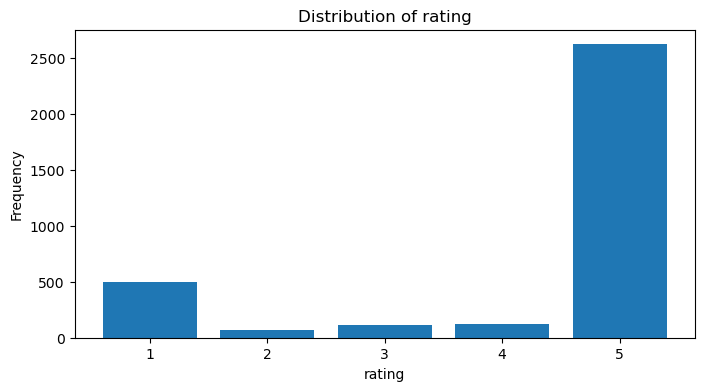

In [50]:
pandas_df = df.groupBy('rating').count().orderBy('rating').toPandas()

figure = plt.figure(figsize=(8, 4))
ax = figure.add_subplot(111)

ax.set_title('Distribution of rating')
ax.bar(pandas_df['rating'], pandas_df['count'])
ax.set_xticks(pandas_df['rating'])
ax.set_xlabel('rating')
ax.set_ylabel('Frequency');

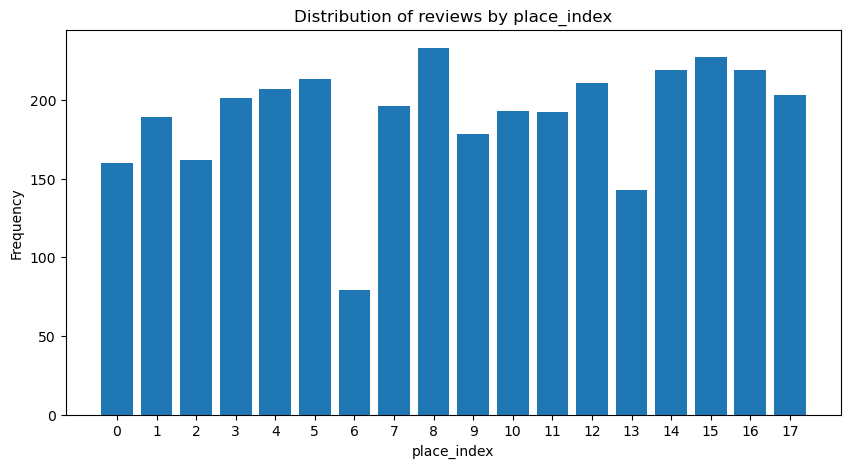

In [51]:
pandas_df = df.groupBy('place_index').count().orderBy('place_index').toPandas()

figure = plt.figure(figsize=(10, 5))
ax = figure.add_subplot(111)

ax.set_title('Distribution of reviews by place_index')
ax.bar(pandas_df['place_index'], pandas_df['count'])
ax.set_xticks(pandas_df['place_index'])
ax.set_xlabel('place_index')
ax.set_ylabel('Frequency');

# Encoding Rating into sentiments
Ratings above 3 stars are considered positive, below 3 stars are considered negative and neutral otherwise.

In [52]:
df_encoded = df.withColumn("sentiment",
    when(col("rating") > 3, "positive")
    .when(col("rating") == 3, "neutral")
    .otherwise("negative")
)
df_encoded.show()

+--------------------+------+-----------+---------+
|              review|rating|place_index|sentiment|
+--------------------+------+-----------+---------+
|3 miếng gà 105k n...|     1|          0| negative|
|Gà ướp vừa vị , m...|     5|          0| positive|
|Thật tuyệt với gà...|     5|          0| positive|
|Quán sạch, đẹp, t...|     5|          0| positive|
|Nhân viên bự con ...|     5|          0| positive|
|Gà giòn tan, nóng...|     5|          0| positive|
|Gà giòn rụm, thấm...|     5|          0| positive|
|Nhân viên thân th...|     5|          0| positive|
|Phục vụ nhanh, nh...|     5|          0| positive|
|Gà rán thì ở đâu ...|     5|          0| positive|
|Mình là fan KFC, ...|     5|          0| positive|
|Nhân viên phục vụ...|     5|          0| positive|
|Gà giòn ngon dù đ...|     5|          0| positive|
|Mình có ghé đây ă...|     5|          0| positive|
|Ghé quán vào 1 bu...|     5|          0| positive|
|Nhân viên thân th...|     5|          0| positive|
|Ăn nhiều br

In [53]:
df_encoded.filter(df_encoded['sentiment'] != 'positive').show()

+--------------------+------+-----------+---------+
|              review|rating|place_index|sentiment|
+--------------------+------+-----------+---------+
|3 miếng gà 105k n...|     1|          0| negative|
|Khi tôi đặt 5 cán...|     1|          0| negative|
|Gọi gà nướng, bắt...|     1|          0| negative|
|Thanh gà trong co...|     2|          0| negative|
|Đặt hàng trên Sho...|     1|          0| negative|
|Làm ăn cà chớn, đ...|     1|          0| negative|
|Làm ăn tệ hại,bỏ ...|     1|          0| negative|
|Thái độ nhân viên...|     1|          0| negative|
|Nhân viên ăn nói ...|     1|          0| negative|
|Đồ ăn ngon bác bả...|     2|          0| negative|
|Lần thứ 3 mua hàn...|     1|          0| negative|
|Đặt grab mua milo...|     1|          0| negative|
|Thời gian chờ lâu...|     1|          0| negative|
|29/11/2021 mình c...|     1|          0| negative|
|Nóng nực, thái độ...|     2|          0| negative|
|Khuyên các bạn mu...|     1|          0| negative|
|Muốn ăn 1 m

# Text Preprocessing

In [54]:
# Define UDF to tokenize using PyVi
@udf
def pyvi_tokenize(text: str) -> str:
    """
    Tokenize Vietnamese text with PyVi.ViTokenizer.
    For more information, see [here]().
    :param str text: The text to tokenize.
    :return: The tokenized text.
    :rtype: str
    """
    return ViTokenizer.tokenize(text)

In [55]:
# Tokenize
tokenized_df = df_encoded.withColumn("review", pyvi_tokenize(col("review")))
tokenized_df.select('review').show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------+
|review                                                                                                                                    |
+------------------------------------------------------------------------------------------------------------------------------------------+
|3 miếng gà 105k như này khác gì 2 miếng rưỡi đâu chứ                                                                                      |
|Gà ướp vừa vị , mọng nước . Dù đông nhưng nhân_viên vẫn rất vui_vẻ nhiệt_tình , đồ ăn đc phục_vụ nhanh                                    |
|Thật tuyệt với gà vị rất ngon , dịch_vụ chu_đáo , nhiệt_tình và nhanh , nhất_định sẽ đến nhiều lần sau                                    |
|Quán sạch , đẹp , thoáng mát , nhân_viên phục_vụ tận_tình và mấy chị quản_lý rất vui_vẻ với khách                                         |
|Nhân_viên bự

# Save results and stop session

In [56]:
tokenized_df.write.csv(
    'hdfs://namenode:9000/review_data/preprocessed',
    header=True,
    encoding='utf-8'
)

In [58]:
# Stop session
spark.stop()